In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import print_function, division
from builtins import range, input

In [3]:

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b


Using TensorFlow backend.


In [0]:
def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)

  return new_model


In [0]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  new_model = Sequential()
  n = 0
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    new_model.add(layer)
    if n >= num_convs:
      break

  return new_model


In [0]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x



58892288/58889256 [==============================] - 1s 0us/step
iter=0, loss=27.417579650878906
iter=1, loss=18.090164184570312
iter=2, loss=17.126619338989258
iter=3, loss=17.12387466430664
iter=4, loss=17.12387466430664
iter=5, loss=17.12387466430664
iter=6, loss=17.12387466430664
iter=7, loss=17.12387466430664
iter=8, loss=17.12387466430664
iter=9, loss=17.12387466430664
duration: 0:43:13.694575


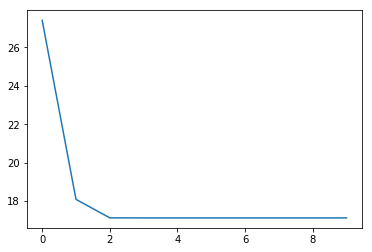

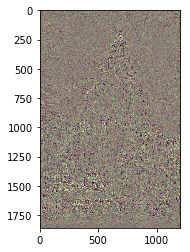

In [7]:
if __name__ == '__main__':

  # open an image
  # feel free to try your own
  # path = '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg'
  path = '/content/drive/My Drive/Neural Style Transfer/building1.jpg'
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  # we'll use this throughout the rest of the script
  batch_shape = x.shape
  shape = x.shape[1:]

  # see the image
  # plt.imshow(img)
  # plt.show()


  # make a content model
  # try different cutoffs to see the images that result
  content_model = VGG16_AvgPool_CutOff(shape, 11)

  # make the target
  target = K.variable(content_model.predict(x))


  # try to match the image

  # define our loss in keras
  loss = K.mean(K.square(target - content_model.output))

  # gradients which are needed by the optimizer
  grads = K.gradients(loss, content_model.input)

  # just like theano.function
  get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)



  from datetime import datetime
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
      func=get_loss_and_grads_wrapper,
      x0=x,
      # bounds=[[-127, 127]]*len(x.flatten()),
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)


  plt.imshow(scale_img(final_img[0]))
  plt.show()